In [ ]:
import os
import re
import inspect
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
! pip3 install bert-tensorflow

     |████████████████████████████████| 71kB 3.3MB/s 


In [2]:
import layers
import models
import utils
import utils_result
import preprocess_data
import bert_input_converter

Using TensorFlow backend.


In [3]:
data_df = pd.read_csv(r"bbc-text.csv")
data_df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data_df["category"] = encoder.fit_transform(data_df["category"])

# FFNN

In [ ]:
model_elmo_ffnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
elmo_layer (ElmoLayer)       (None, 1024)              4         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285  

# CNN

In [ ]:
model_elmo_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
elmo_layer (ElmoLayer)          (None, None, 1024)   0           input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 1024)   0           elmo_layer[0][0]                 
__________________________________________________________________________________________________
reshape (Reshape)               (None, None, 1024, 1 0           spatial_dropout1d[0][0]          
______________________________________________________________________________________________

# RNN

In [ ]:
model_elmo_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
elmo_layer (ElmoLayer)          (None, None, 1024)   0           input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 1024)   0           elmo_layer[0][0]                 
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 64)     202944      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

# CHARACTER LEVEL

In [ ]:
from models import model_rnn

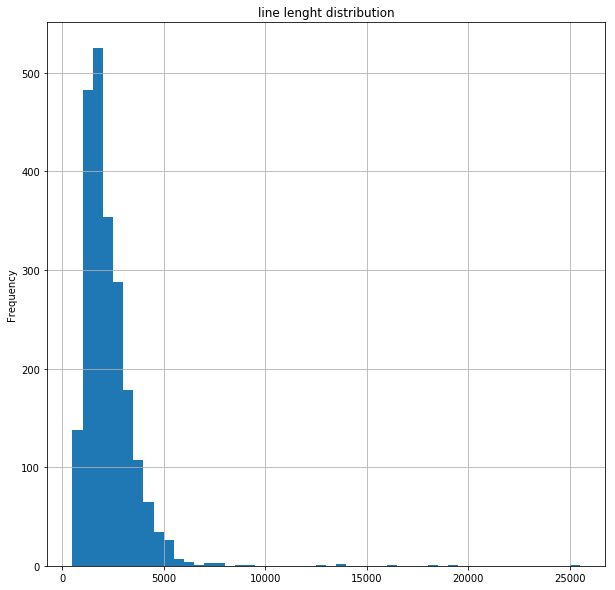

In [20]:
data_df["text"].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [ ]:
from preprocess_data import preprocess_data_char
from utils_result import save_report, update_fit_params, evaluation

# preprocess data
(x_train, y_train), (x_val, y_val), (x_test, y_test), int2char = preprocess_data_char(data_df, x_label="text", y_label="category", max_len_seq=500)

In [ ]:
# general parameter setting
tensorboard_params = {
    "histogram_freq": 1,
    "write_graph": True,
    "write_images": True
}

fit_params = {
    "x": x_train,
    "y": y_train,
    "epochs": 10,
    "batch_size": 32,
    "validation_data": (x_val, y_val) 
}

input_params = {
    "shape": x_train.shape[1:],
    "dtype": x_train.dtype
}

test_result_dict = {}

In [ ]:
VOCAB_SIZE = len(int2char)
MAX_LEN_SEQ = x_train.shape[1]
EMB_OUTPUT_DIM = min(32, VOCAB_SIZE)

In [24]:
# parameters setting
el_params = {
    "input_dim": VOCAB_SIZE,
    "output_dim": EMB_OUTPUT_DIM,
    "input_length": MAX_LEN_SEQ,
    "trainable": True
}

model_params_el = {
    "input_layer": "simple_input",
    "emb_layer": "Embedding",
    "input_params": input_params,
    "emb_params": el_params,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_el"
model_el = model_rnn(model_params_el)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

W0819 13:24:45.056422 140695736989568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Evaluating: batch 10 ends at 13:58:53.925143
1557/1557 [==============================] - 201s 129ms/sample - loss: 1.4345 - acc: 0.3899 - val_loss: 1.4260 - val_acc: 0.3994


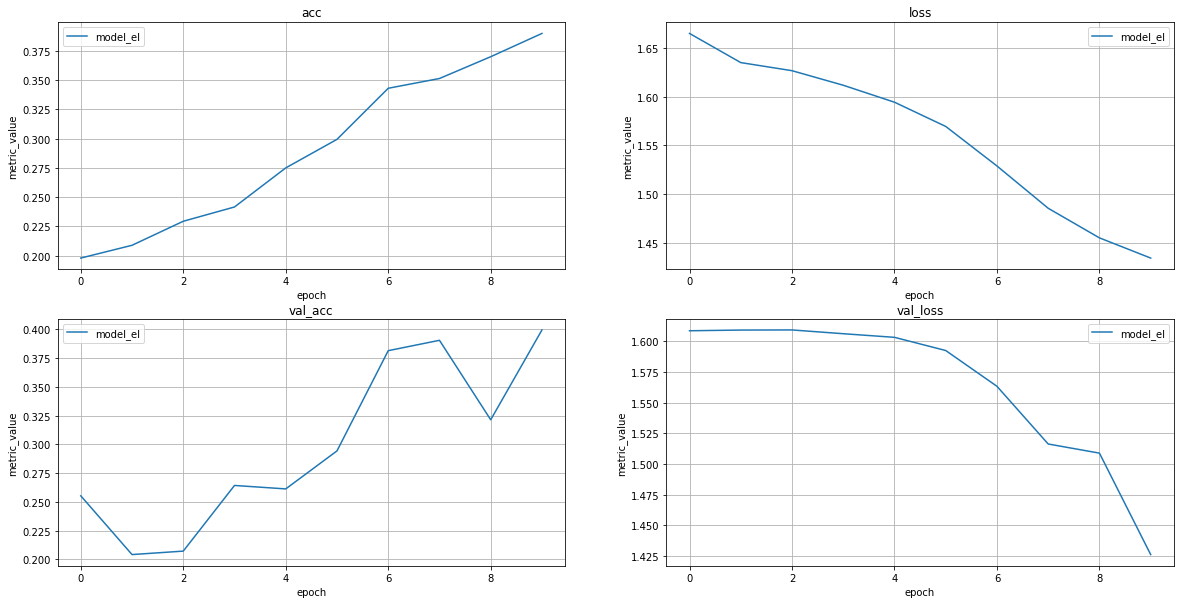

In [25]:
# training
model_el.fit(**fit_params);
model_el = save_report(model=model_el, model_name=model_name, markered_path=markered_path)

In [ ]:
# evaluation
test_result_dict = evaluation(model=model_el, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

# Phrase Level

In [ ]:
from models import model_ffnn, model_cnn, model_rnn

In [ ]:
from preprocess_data import preprocess_data_word
from utils_result import save_report, update_fit_params, evaluation

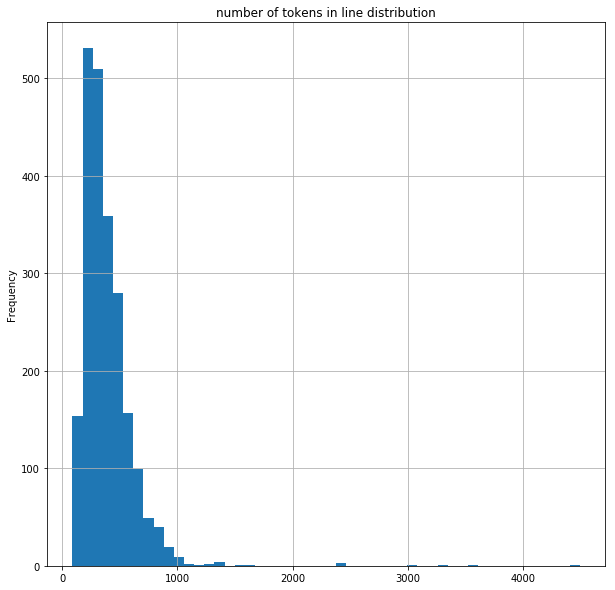

In [ ]:
data_df["text"].str.split().str.len().plot(kind="hist", title="number of tokens in line distribution", grid=True, figsize=(10,10), bins=50);

In [ ]:
# preprocess data
(x_train, y_train), (x_val, y_val), (x_test, y_test), data = preprocess_data_word(data_df, x_label="text", y_label="category", max_len_seq=500)

## USE

In [ ]:
# general parameter setting
tensorboard_params = None

fit_params = {
    "x": x_train,
    "y": y_train,
    "epochs": 10,
    "batch_size": 32,
    "validation_data": (x_val, y_val) 
}

input_params = {
    "shape": (1,),
    "dtype": tf.string
}

test_result_dict = {}

In [ ]:
# parameters setting
use_params_ffnn = {
    "trainable": True,
    "output_dim": 512
}

params_use_raw = {
    "input_layer": "simple_input",
    "emb_layer": "USE",
    "input_params": input_params,
    "emb_params": use_params_ffnn,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_use_ffnn"
model_use_ffnn = model_ffnn(params_use_raw)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

W0819 08:55:22.553093 139835096467328 deprecation_wrapper.py:119] From /content/layers.py:148: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.

W0819 08:55:29.907812 139835096467328 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 08:55:30.094388 139835096467328 deprecation_wrapper.py:119] From /content/models.py:118: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0819 08:55:31.487181 139835096467328 deprecation_wrapper.py:119] From /content/models.py:119: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initial

In [ ]:
# training
model_use_ffnn.fit(**fit_params);
model_use_ffnn = save_report(model=model_use_ffnn, model_name=model_name, markered_path=markered_path)

W0819 08:55:33.805752 139835096467328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1557 samples, validate on 333 samples


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ValueError: ignored

In [ ]:
# evaluation
test_result_dict = evaluation(model=model_use_ffnn, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

# ELMO

In [ ]:
# general parameter setting
tensorboard_params = None

fit_params = {
    "x": x_train,
    "y": y_train,
    "epochs": 10,
    "batch_size": 32,
    "validation_data": (x_val, y_val) 
}

input_params = {
    "shape": (1, ),
    "dtype": tf.string
}

test_result_dict = {}

## FFNN

In [ ]:
# parameters setting
elmo_params_ffnn = {
    "trainable": True,
    "output_dim": 1024
}

params_elmo_raw = {
    "input_layer": "simple_input",
    "emb_layer": "Elmo",
    "input_params": input_params,
    "emb_params": elmo_params_ffnn,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_elmo_ffnn"
model_elmo_ffnn = model_ffnn(params_elmo_raw)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

Train on 1557 samples, validate on 333 samples
Epoch 1/10
1557/1557 [==============================] - 138s 88ms/sample - loss: 0.1982 - acc: 0.9255 - val_loss: 0.2174 - val_acc: 0.9670
Epoch 2/10
1557/1557 [==============================] - 130s 83ms/sample - loss: 0.0669 - acc: 0.9807 - val_loss: 0.1173 - val_acc: 0.9880
Epoch 3/10
1557/1557 [==============================] - 130s 84ms/sample - loss: 0.0559 - acc: 0.9820 - val_loss: 0.0881 - val_acc: 0.9850
Epoch 4/10
1557/1557 [==============================] - 130s 84ms/sample - loss: 0.0363 - acc: 0.9904 - val_loss: 0.0648 - val_acc: 0.9820
Epoch 5/10
1557/1557 [==============================] - 131s 84ms/sample - loss: 0.0306 - acc: 0.9923 - val_loss: 0.0549 - val_acc: 0.9820
Epoch 6/10
1557/1557 [==============================] - 130s 83ms/sample - loss: 0.0309 - acc: 0.9897 - val_loss: 0.0576 - val_acc: 0.9820
Epoch 7/10
1557/1557 [==============================] - 130s 83ms/sample - loss: 0.0231 - acc: 0.9929 - val_loss: 0.072

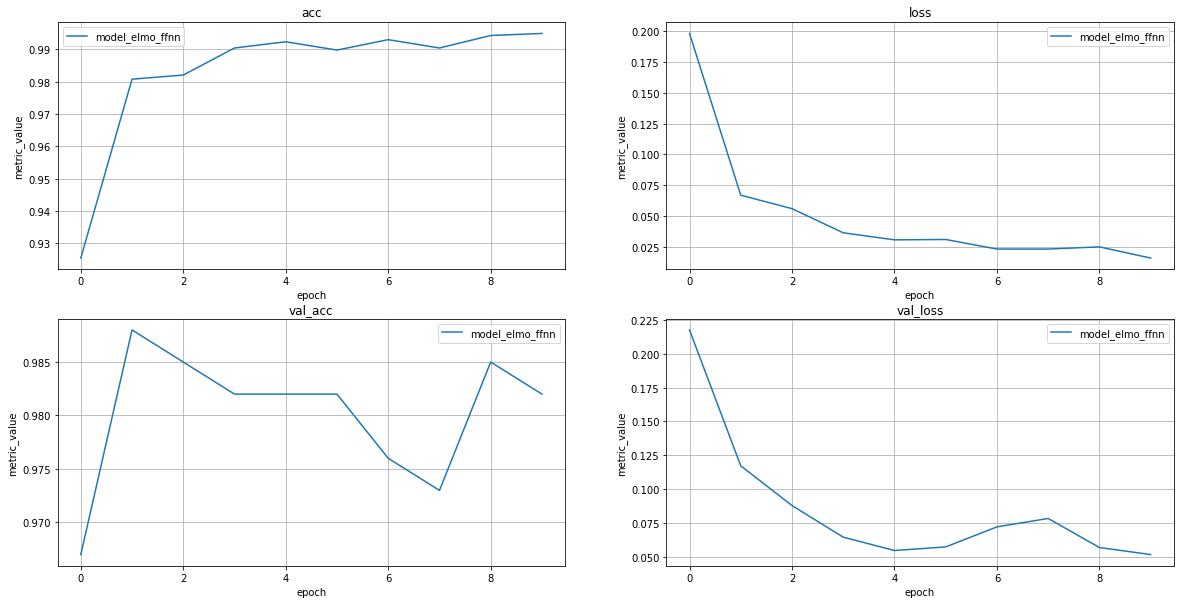

In [ ]:
# training
model_elmo_ffnn.fit(**fit_params);
model_elmo_ffnn = save_report(model=model_elmo_ffnn, model_name=model_name, markered_path=markered_path)

In [ ]:
# evaluation
test_result_dict = evaluation(model=model_elmo_ffnn, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_elmo_ffnn, to 0.9582


## CNN

In [ ]:
# parameters setting
elmo_params_cnn = {
    "trainable": False,
    "output_dim": 1024,
    "output_type": "elmo"
}

model_params_elmo_cnn = {
    "input_layer": "simple_input",
    "emb_layer": "Elmo",
    "input_params": input_params,
    "emb_params": elmo_params_cnn,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_elmo_cnn"
model_elmo_cnn = model_cnn(model_params_elmo_cnn)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

Train on 1557 samples, validate on 333 samples
Epoch 1/10
1557/1557 [==============================] - 133s 86ms/sample - loss: 0.5031 - acc: 0.8658 - val_loss: 0.2891 - val_acc: 0.9700
Epoch 2/10
1557/1557 [==============================] - 130s 84ms/sample - loss: 0.2299 - acc: 0.9570 - val_loss: 0.1857 - val_acc: 0.9790
Epoch 3/10
1557/1557 [==============================] - 130s 84ms/sample - loss: 0.1836 - acc: 0.9672 - val_loss: 0.1265 - val_acc: 0.9850
Epoch 4/10
1557/1557 [==============================] - 131s 84ms/sample - loss: 0.1400 - acc: 0.9705 - val_loss: 0.0960 - val_acc: 0.9790
Epoch 5/10
1557/1557 [==============================] - 130s 84ms/sample - loss: 0.1123 - acc: 0.9769 - val_loss: 0.0874 - val_acc: 0.9790
Epoch 6/10
1557/1557 [==============================] - 131s 84ms/sample - loss: 0.1089 - acc: 0.9788 - val_loss: 0.0984 - val_acc: 0.9730
Epoch 7/10
1557/1557 [==============================] - 130s 84ms/sample - loss: 0.0991 - acc: 0.9782 - val_loss: 0.086

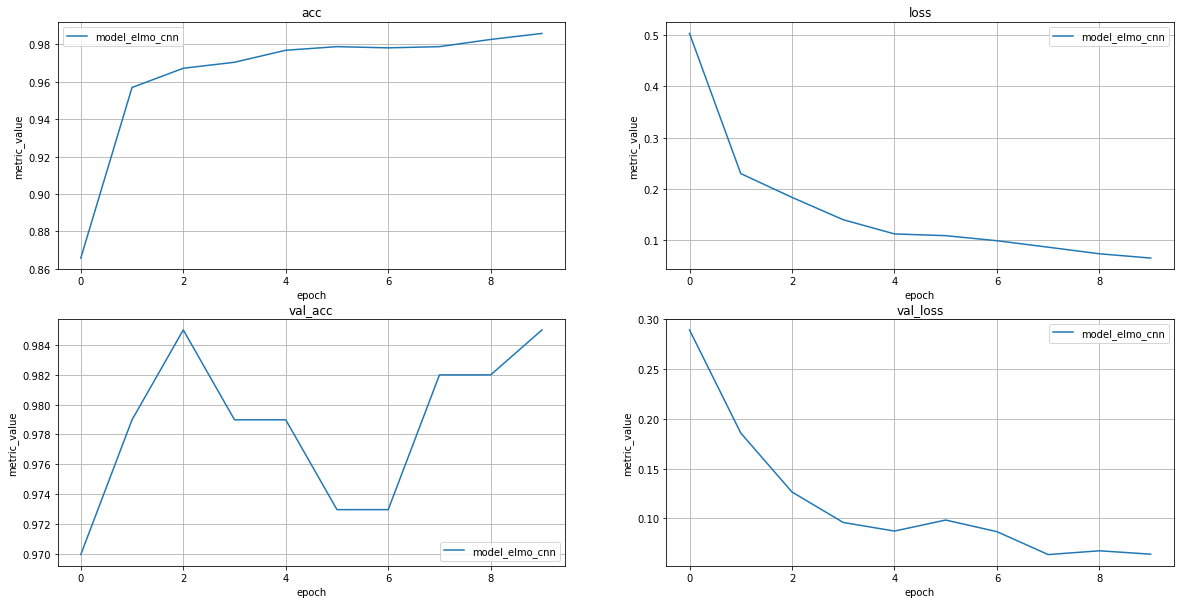

In [ ]:
# training
model_elmo_cnn.fit(**fit_params);
model_elmo_cnn = save_report(model=model_elmo_cnn, model_name=model_name, markered_path=markered_path)

In [ ]:
# evaluation
test_result_dict = evaluation(model=model_elmo_cnn, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_elmo_cnn, to 0.9672


## RNN

In [ ]:
# parameters setting
elmo_params_rnn = {
    "trainable": False,
    "output_dim": 1024,
    "output_type": "elmo"
}

model_params_elmo_rnn = {
    "input_layer": "simple_input",
    "emb_layer": "Elmo",
    "input_params": input_params,
    "emb_params": elmo_params_rnn,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_elmo_rnn"
model_elmo_rnn = model_rnn(model_params_elmo_rnn)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

Train on 1557 samples, validate on 333 samples
Epoch 1/10
1557/1557 [==============================] - 294s 189ms/sample - loss: 0.9455 - acc: 0.6564 - val_loss: 0.5245 - val_acc: 0.9700
Epoch 2/10
1557/1557 [==============================] - 289s 185ms/sample - loss: 0.2773 - acc: 0.9268 - val_loss: 0.2013 - val_acc: 0.9760
Epoch 3/10
1557/1557 [==============================] - 289s 185ms/sample - loss: 0.1897 - acc: 0.9512 - val_loss: 0.1041 - val_acc: 0.9790
Epoch 4/10
1557/1557 [==============================] - 288s 185ms/sample - loss: 0.1512 - acc: 0.9608 - val_loss: 0.0902 - val_acc: 0.9760
Epoch 5/10
1557/1557 [==============================] - 288s 185ms/sample - loss: 0.1127 - acc: 0.9666 - val_loss: 0.0762 - val_acc: 0.9790
Epoch 6/10
1557/1557 [==============================] - 289s 185ms/sample - loss: 0.1110 - acc: 0.9692 - val_loss: 0.0766 - val_acc: 0.9760
Epoch 7/10
1557/1557 [==============================] - 288s 185ms/sample - loss: 0.0913 - acc: 0.9717 - val_loss

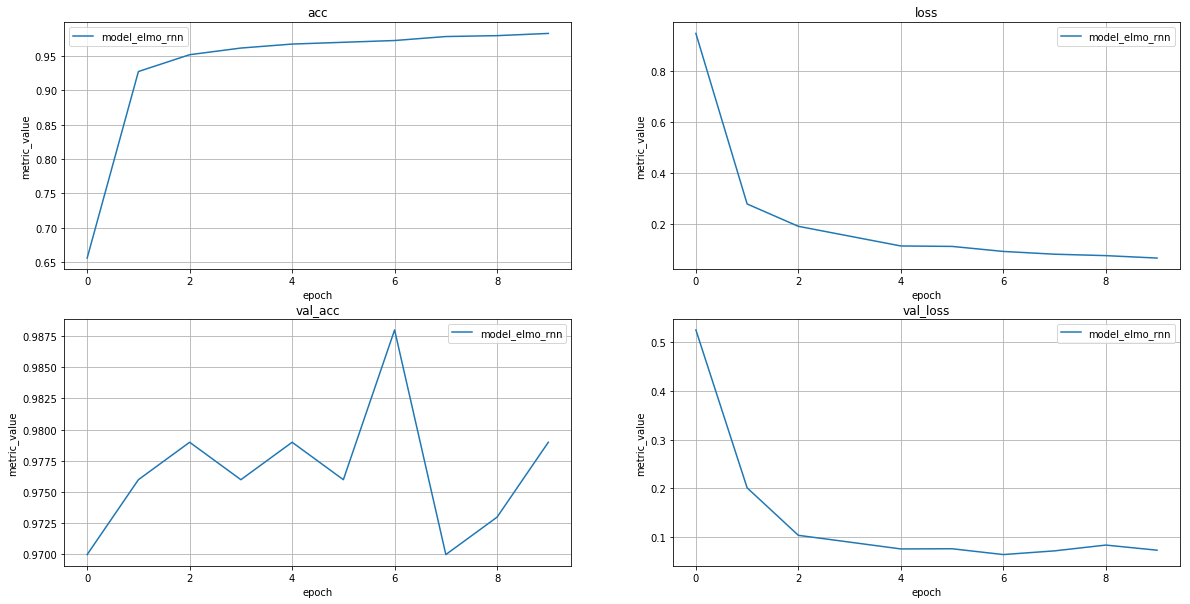

In [37]:
# training
model_elmo_rnn.fit(**fit_params);
model_elmo_rnn = save_report(model_elmo_rnn, model_name=model_name, markered_path=markered_path)

In [38]:
# evaluation
test_result_dict = evaluation(model=model_elmo_rnn, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_elmo_rnn, to 0.9791


# BERT

In [ ]:
from bert_input_converter import get_proper_input_to_bert

In [8]:
MAX_LEN_SEQ = 500
N_FINE_TUNE_LAYERS = 1
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_proper_input_to_bert(data_df, x_label="text", y_label="category", max_len_seq=MAX_LEN_SEQ)

W0819 11:17:23.022281 140695736989568 deprecation_wrapper.py:119] From /content/bert_input_converter.py:45: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0819 11:17:23.946574 140695736989568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [ ]:
# general parameter setting
tensorboard_params = None

fit_params = {
    "x": x_train,
    "y": y_train,
    "epochs": 10,
    "batch_size": 32,
    "validation_data": (x_val, y_val) 
}

input_params = {
    "shape": (MAX_LEN_SEQ, ),
    "dtype": "int32"
}

test_result_dict = {}

## CNN

In [10]:
# parameters setting
bert_params_cnn = {
    "trainable": True,
    "output_dim": 768,
    "output_type": "sequence_output",
    "signature": "tokens",
    "n_fine_tune_layers": N_FINE_TUNE_LAYERS
}

model_params_bert_cnn = {
    "input_layer": "bert_input",
    "emb_layer": "Bert",
    "input_params": input_params,
    "emb_params": bert_params_cnn,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_bert_cnn"
model_bert_cnn = model_cnn(model_params_bert_cnn)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

W0819 11:18:01.663785 140695736989568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 11:18:02.308284 140695736989568 deprecation_wrapper.py:119] From /content/models.py:93: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.



Train on 1557 samples, validate on 333 samples


W0819 11:18:06.575648 140695736989568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
1557/1557 [==============================] - 106s 68ms/sample - loss: 0.4916 - acc: 0.8664 - val_loss: 0.1311 - val_acc: 0.9670
Epoch 2/10
1557/1557 [==============================] - 101s 65ms/sample - loss: 0.1674 - acc: 0.9782 - val_loss: 0.0462 - val_acc: 0.9910
Epoch 3/10
1557/1557 [==============================] - 101s 65ms/sample - loss: 0.1004 - acc: 0.9929 - val_loss: 0.0354 - val_acc: 0.9910
Epoch 4/10
1557/1557 [==============================] - 100s 64ms/sample - loss: 0.0715 - acc: 0.9936 - val_loss: 0.0540 - val_acc: 0.9880
Epoch 5/10
1557/1557 [==============================] - 99s 64ms/sample - loss: 0.0626 - acc: 0.9936 - val_loss: 0.0424 - val_acc: 0.9850
Epoch 6/10
1557/1557 [==============================] - 100s 64ms/sample - loss: 0.0426 - acc: 0.9968 - val_loss: 0.0680 - val_acc: 0.9790
Epoch 7/10
1557/1557 [==============================] - 100s 64ms/sample - loss: 0.0399 - acc: 0.9961 - val_loss: 0.0777 - val_acc: 0.9820
Epoch 8/10
1557/1557 [======

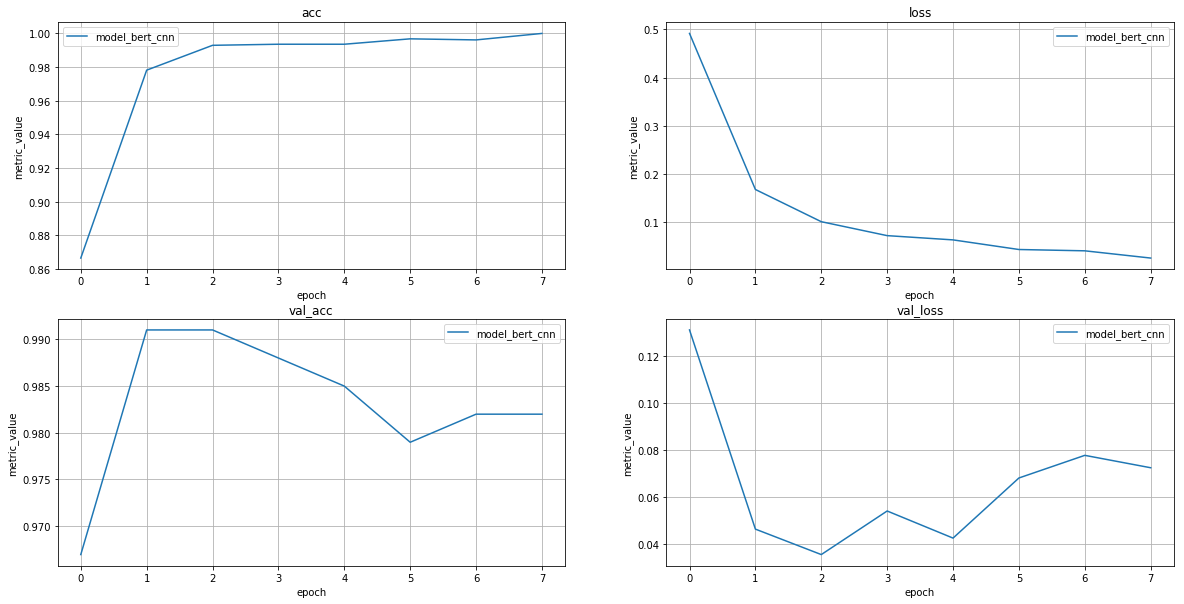

In [11]:
# training
model_bert_cnn.fit(**fit_params);
model_bert_cnn = save_report(model=model_bert_cnn, model_name=model_name, markered_path=markered_path)

In [12]:
# evaluation
test_result_dict = evaluation(model=model_bert_cnn, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_bert_cnn, to 0.2016


## FFNN

In [13]:
# parameters setting
bert_params_ffnn = {
    "trainable": False,
    "output_dim": 768,
    "output_type": "pooled_output",
    "signature": "tokens",
    "n_fine_tune_layers": N_FINE_TUNE_LAYERS
}

model_params_bert_ffnn = {
    "input_layer": "bert_input",
    "emb_layer": "Bert",
    "input_params": input_params,
    "emb_params": bert_params_ffnn,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_bert_ffnn"
model_bert_ffnn = model_ffnn(model_params_bert_ffnn)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

W0819 11:41:48.173997 140695736989568 deprecation_wrapper.py:119] From /content/models.py:121: The name tf.tables_initializer is deprecated. Please use tf.compat.v1.tables_initializer instead.



Train on 1557 samples, validate on 333 samples
Epoch 1/10
1557/1557 [==============================] - 86s 55ms/sample - loss: 0.7595 - acc: 0.7386 - val_loss: 1.5016 - val_acc: 0.2943
Epoch 2/10
1557/1557 [==============================] - 84s 54ms/sample - loss: 0.3307 - acc: 0.8927 - val_loss: 1.1423 - val_acc: 0.6456
Epoch 3/10
1557/1557 [==============================] - 83s 54ms/sample - loss: 0.2637 - acc: 0.9120 - val_loss: 1.6106 - val_acc: 0.3784
Epoch 4/10
1557/1557 [==============================] - 84s 54ms/sample - loss: 0.2162 - acc: 0.9409 - val_loss: 0.6231 - val_acc: 0.7628
Epoch 5/10
1557/1557 [==============================] - 83s 54ms/sample - loss: 0.1620 - acc: 0.9525 - val_loss: 0.6570 - val_acc: 0.7568
Epoch 6/10
1557/1557 [==============================] - 83s 54ms/sample - loss: 0.1538 - acc: 0.9486 - val_loss: 0.5785 - val_acc: 0.7628
Epoch 7/10
1557/1557 [==============================] - 83s 54ms/sample - loss: 0.1865 - acc: 0.9390 - val_loss: 0.4216 - val

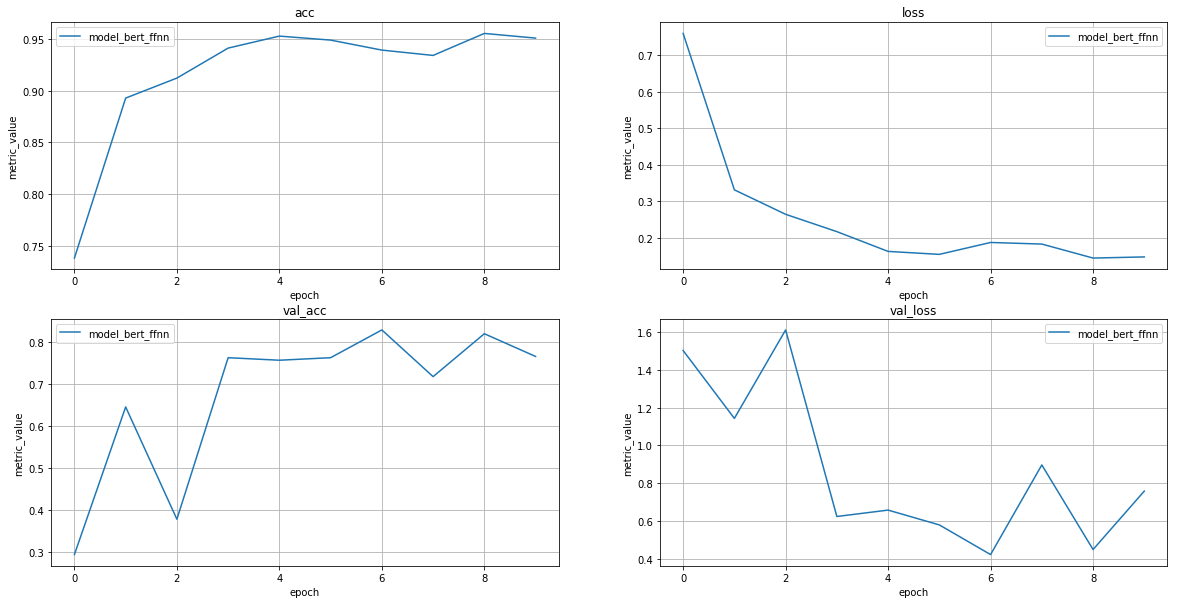

In [14]:
# training
model_bert_ffnn.fit(**fit_params);
model_bert_ffnn = save_report(model=model_bert_ffnn, model_name=model_name, markered_path=markered_path)

In [15]:
# evaluation
test_result_dict = evaluation(model=model_bert_ffnn, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_bert_ffnn, to 0.1981


## RNN

In [16]:
# parameters setting
bert_params_rnn = {
    "trainable": True,
    "output_dim": 768,
    "output_type": "sequence_output",
    "signature": "tokens",
    "n_fine_tune_layers": N_FINE_TUNE_LAYERS
}

model_params_bert_rnn = {
    "input_layer": "bert_input",
    "emb_layer": "Bert",
    "input_params": input_params,
    "emb_params": bert_params_rnn,
    "out_activation": "softmax",
    "out_units": np.unique(y_train).shape[0],
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam"
}
model_name = "model_elmo_rnn"
model_bert_rnn = model_rnn(model_params_bert_rnn)
fit_params, markered_path = update_fit_params(fit_params, model_name=model_name, tensorboard_params=tensorboard_params)

W0819 11:56:08.583608 140695736989568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 11:56:08.584961 140695736989568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 11:56:08.586315 140695736989568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is de

Train on 1557 samples, validate on 333 samples
Epoch 1/10
1557/1557 [==============================] - 251s 161ms/sample - loss: 1.1155 - acc: 0.5626 - val_loss: 0.2895 - val_acc: 0.9820
Epoch 2/10
1557/1557 [==============================] - 247s 158ms/sample - loss: 0.2288 - acc: 0.9557 - val_loss: 0.0960 - val_acc: 0.9790
Epoch 3/10
1557/1557 [==============================] - 244s 157ms/sample - loss: 0.1115 - acc: 0.9775 - val_loss: 0.0694 - val_acc: 0.9820
Epoch 4/10
1557/1557 [==============================] - 243s 156ms/sample - loss: 0.0669 - acc: 0.9884 - val_loss: 0.0296 - val_acc: 0.9940
Epoch 5/10
1557/1557 [==============================] - 244s 157ms/sample - loss: 0.0564 - acc: 0.9846 - val_loss: 0.0397 - val_acc: 0.9880
Epoch 6/10
1557/1557 [==============================] - 245s 157ms/sample - loss: 0.0587 - acc: 0.9839 - val_loss: 0.1004 - val_acc: 0.9820
Epoch 7/10
1557/1557 [==============================] - 245s 157ms/sample - loss: 0.0344 - acc: 0.9929 - val_loss

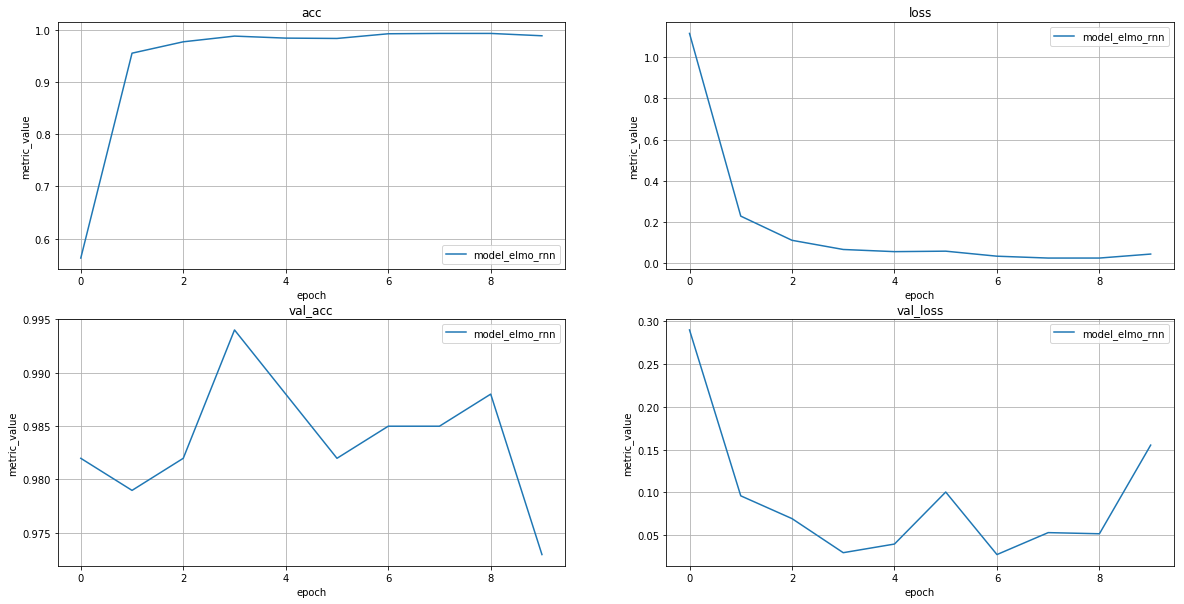

In [17]:
# training
model_bert_rnn.fit(**fit_params);
model_bert_rnn = save_report(model=model_bert_rnn, model_name=model_name, markered_path=markered_path)

In [18]:
# evaluation
test_result_dict = evaluation(model=model_bert_rnn, x_test=x_test, y_test=y_test, model_name=model_name, test_result_dict=test_result_dict)

Wynik na zbiorze testowym modelu model_elmo_rnn, to 0.2024
